In [168]:
import os
import time

import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold


import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from keras.layers import Dense, LSTM, Embedding, LeakyReLU, BatchNormalization, Dropout, Input, ReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop 

### Load the dataset

In [169]:
# Wczytanie danych
data_path = 'original_data/GSE158508_normalized_counts.tsv'
data = pd.read_csv(data_path, sep='\t', index_col=0)

# Transpozycja danych
data = data.T

# Zapisanie oryginalnych nazw kolumn
col_names = data.columns

# Użycie VarianceThreshold do usunięcia kolumn, które mają małą wariancję

# liczba kolumn - wariancja
# 25 - 5.2
# 50 - 4.44
# 100 - 3.93
# 200 - 3.42
# 500 - 2.834
# 1000 - 2.399
# 2000 - 1.963
# 5000 - 1.231182
selector = VarianceThreshold(threshold=3.42)
data = selector.fit_transform(data)

# Przekształcenie tablicy NumPy z powrotem na DataFrame i przypisanie nazw kolumn
data = pd.DataFrame(data, columns=col_names[selector.get_support()])

# Usuwanie kolumn, które mają taką samą wartość we wszystkich wierszach
# data_reduced = data_reduced.loc[:, data_reduced.nunique() > 1]

# Zapisanie kształtu danych
data_shape = data.shape[1]

# Zapisanie nazw kolumn dla późniejszego użycia
col_names = data.columns.values

# Zapisanie minimalnych i maksymalnych wartości oryginalnych
original_min = data.min().min()
original_max = data.max().max()

print(data.shape)


(69, 200)


In [170]:
# Function to scale data between -1 and 1
def scale_data(data):
    data = (data - original_min) / (original_max - original_min)
    data = data * 2 - 1
    return data

In [171]:
original_data = data
data = scale_data(data)

In [172]:
data.describe()

,ENSG00000000938,ENSG00000005844,ENSG00000007312,ENSG00000010327,ENSG00000011422,ENSG00000013441,ENSG00000018280,ENSG00000027075,ENSG00000028137,ENSG00000035681,...,ENSG00000198909,ENSG00000205744,ENSG00000206503,ENSG00000213983,ENSG00000223553,ENSG00000229164,ENSG00000234745,ENSG00000240356,ENSG00000244734,ENSG00000257207
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,-0.461462,-0.570087,-0.728411,-0.608887,-0.663215,-0.431176,-0.604495,-0.637554,-0.604383,-0.704217,...,-0.670768,-0.532708,-0.609236,-0.627654,-0.675851,-0.562306,-0.518696,-0.328416,0.254028,-0.332821
std,0.243587,0.268986,0.241756,0.275487,0.289669,0.256132,0.278910,0.242506,0.313841,0.249375,...,0.243626,0.248219,0.364506,0.242540,0.253921,0.250135,0.463359,0.309489,0.273158,0.362507
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.301386,-1.000000
25%,-0.600571,-0.754344,-1.000000,-0.806696,-1.000000,-0.621255,-0.828189,-0.813894,-0.836987,-1.000000,...,-0.872182,-0.684128,-0.877369,-0.800056,-1.000000,-0.767432,-0.876983,-0.537890,0.075175,-0.783572
50%,-0.457989,-0.533541,-0.754021,-0.585554,-0.710931,-0.408263,-0.605252,-0.641473,-0.650126,-0.676881,...,-0.657141,-0.516817,-0.780734,-0.620876,-0.600571,-0.575434,-0.805098,-0.200754,0.229437,-0.142356
75%,-0.319895,-0.368786,-0.523583,-0.398843,-0.515068,-0.215330,-0.382839,-0.459490,-0.374759,-0.533393,...,-0.498178,-0.349193,-0.362133,-0.465014,-0.436707,-0.376563,0.011491,-0.125330,0.414105,-0.075876
max,0.087917,-0.094889,-0.225348,-0.024045,0.087303,-0.015074,-0.024465,-0.188293,0.099707,-0.195524,...,-0.173041,-0.108473,0.205030,-0.139756,-0.246578,0.026666,0.225065,0.139908,1.000000,0.124808


### Create the models

#### The Generator

In [174]:
def build_generator(latent_dim, data_shape, num_layers=4, num_neurons=256, activation='relu', dropout=0.2):
    model = Sequential()

    model.add(Dense(num_neurons, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(ReLU())

    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons))
        model.add(BatchNormalization())
        model.add(ReLU())

    model.add(Dense(data_shape, activation='tanh'))

    noise = Input(shape=(latent_dim,))
    generated_data = model(noise)

    return Model(noise, generated_data)

#### The Discriminator

In [175]:
def build_discriminator(data_shape, num_layers=2, num_neurons=128, activation='relu', dropout=0.2):
    model = Sequential()

    model.add(Dense(num_neurons, input_dim=data_shape))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons))
        model.add(LeakyReLU())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))

    data = Input(shape=(data_shape,))
    validity = model(data)

    return Model(data, validity)

### Wasserstein Loss function

In [176]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)


### Gradient Penalty function

In [177]:
def gradient_penalty(real_data, fake_data, discriminator):
    alpha = tf.random.normal([real_data.shape[0], 1], 0.0, 1.0)
    interpolated = alpha * real_data + (1 - alpha) * fake_data
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        prediction = discriminator(interpolated)
    gradients = tape.gradient(prediction, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
    penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return penalty

### Compile the models

In [178]:
# Wymiary przestrzeni ukrytej
latent_dim = 64

# Budowa i kompilacja dyskryminatora
discriminator = build_discriminator(data_shape)
discriminator_optimizer = RMSprop(learning_rate=0.0001)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer)

# Budowa generatora
generator = build_generator(latent_dim, data_shape)

# Generator bierze szum jako wejście i generuje dane
z = Input(shape=(latent_dim,))
generated_data = generator(z)

# Tylko generator jest trenowany
discriminator.trainable = False

# Dyskryminator bierze wygenerowane dane jako wejście i określa ich prawdziwość
validity = discriminator(generated_data)

# Połączony model (stacked generator and discriminator)
combined = Model(z, validity)
combined_optimizer = RMSprop(learning_rate=0.0001)
combined.compile(loss='binary_crossentropy', optimizer=combined_optimizer)


### Save checkpoints

In [151]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator=generator,
#                                  discriminator=discriminator)

### Gradient Norms

In [179]:
def compute_gradient_norm(model, real_data, fake_data):
    with tf.GradientTape() as tape:
        # Obliczanie straty dyskryminatora
        real_output = model(real_data, training=True)
        fake_output = model(fake_data, training=True)
        loss = wasserstein_loss(real_output, fake_output)

    # Obliczanie gradientów względem wag dyskryminatora
    gradients = tape.gradient(loss, model.trainable_variables)
    # Obliczanie normy gradientów
    gradient_norm = tf.linalg.global_norm(gradients)
    return gradient_norm.numpy()

In [180]:
def matrix_sqrt_newton_schulz(A, num_iters=10):
    dim = tf.shape(A)[0]
    Y = A
    I = tf.eye(dim, dtype=A.dtype)
    Z = tf.eye(dim, dtype=A.dtype)

    for i in range(num_iters):
        T = 0.5 * (3.0 * I - Z @ Y)
        Y = Y @ T
        Z = T @ Z
    return Y

In [181]:
from sklearn.utils.extmath import randomized_svd
def matrix_sqrt_via_svd(matrix):
    """ Przybliżony pierwiastek macierzy przy użyciu randomized SVD. """
    U, S, V = randomized_svd(matrix, n_components=100)
    sqrt_S = np.sqrt(S)
    return np.dot(U * sqrt_S, V)

In [182]:
def calculate_fid(real_data, generated_data):
    # Przygotowanie danych
    start = time.time()
    real_data = real_data.astype('float32')
    generated_data = generated_data.astype('float32')
    print("Prepared data in {} seconds".format(time.time() - start))

    # Obliczanie średniej i macierzy kowariancji
    start = time.time()
    mu1, sigma1 = real_data.mean(axis=0), np.cov(real_data, rowvar=False)
    print("Computed real data mean and covariance in {} seconds".format(time.time() - start))

    start = time.time()
    mu2, sigma2 = generated_data.mean(axis=0), np.cov(generated_data, rowvar=False)
    print("Computed generated data mean and covariance in {} seconds".format(time.time() - start))

    # Dodanie stabilizacji numerycznej do macierzy kowariancji
    sigma1 += np.eye(sigma1.shape[0]) * 1e-6
    sigma2 += np.eye(sigma2.shape[0]) * 1e-6

    ssdiff = tf.reduce_sum(tf.square(mu1 - mu2), axis=-1)

    # Obliczanie przybliżonego pierwiastka z iloczynu macierzy kowariancji
    sqrt_prod = matrix_sqrt_via_svd(sigma1 @ sigma2)

    # Obliczanie śladu (trace) macierzy kowariancji i pierwiastka z ich iloczynu
    trace_sum = np.trace(sigma1) + np.trace(sigma2) - 2.0 * np.trace(sqrt_prod)

    ssdiff = tf.cast(ssdiff, tf.float32)
    trace_sum = tf.cast(trace_sum, tf.float32)
    print(f"ssdiff: {ssdiff}, trace_sum: {trace_sum}")

    fid_score = ssdiff + trace_sum

    return fid_score

In [183]:
def inverse_scale_data(generated_data, original_min, original_max):
    generated_data = (generated_data + 1) / 2
    generated_data = generated_data * (original_max - original_min) + original_min
    return generated_data

def generate_data(generator, n_samples):
    noise = np.random.normal(0, 1, size=(n_samples, latent_dim))
    generated_data = generator.predict(noise)
    generated_data = inverse_scale_data(generated_data, original_min, original_max)
    return generated_data

### Define the training loop

In [184]:
def train(generator, discriminator, combined, data, latent_dim, epochs, batch_size=128, n_critic=1, lambda_gp=10.0, save_interval=50):
    # Ładowanie i skalowanie danych
    X_train = data.values

    # Initialize lists to store loss values
    d_loss_list = []
    g_loss_list = []
    fid_score_list = []
    gradient_norm_list = []
    gradient_norm = 0
    fid_score = 0
    best_fid_score = 1000000
    best_generator = generator
    patience_stop = 15
    patience_decay = 4
    # Pętla po epokach
    for epoch in range(epochs):
        start = time.time()
        for _ in range(n_critic):
            # ---------------------
            #  Trenowanie dyskryminatora
            # ---------------------

            discriminator.trainable = True

            # Wybieranie losowych próbek
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_data = X_train[idx]

            # Generowanie nowego szumu
            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Generowanie nowych danych
            generated_data = generator.predict(noise, verbose = 0)

            # Trenowanie dyskryminatora
            d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1), dtype=np.float32))
            d_loss_fake = discriminator.train_on_batch(generated_data, np.zeros((batch_size, 1), dtype=np.float32))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            #d_loss = d_loss_fake - d_loss_real + lambda_gp * gradient_penalty(real_data, generated_data, discriminator)

            gradient_norm = compute_gradient_norm(discriminator, real_data, generated_data)
            gradient_norm_list.append(gradient_norm)

        # ---------------------
        #  Trenowanie generatora
        # ---------------------

        discriminator.trainable = False

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        
        # Chcemy, aby dyskryminator uznał wygenerowane dane za prawdziwe
        valid_y = np.array([1] * batch_size, dtype=np.float32)

        # Trenowanie generatora
        g_loss = combined.train_on_batch(noise, valid_y)

        # Append loss values to lists
        d_loss_list.append(d_loss)
        g_loss_list.append(g_loss)

        # Zapisywanie postępów
        if epoch % save_interval == 0:
            noise = np.random.normal(0, 1, size=(original_data.shape[0], latent_dim))
            generated_data = generator.predict(noise)
            generated_data = inverse_scale_data(generated_data, original_min, original_max)
            fid_score = calculate_fid(original_data, generated_data)
            fid_score_list.append(fid_score)
            print("%d [D loss: %f] [G loss: %f] [D gradient norm: %f] [FID score: %f]" % (epoch, d_loss, g_loss, gradient_norm, fid_score))
            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            if fid_score < best_fid_score:
                best_fid_score = fid_score
                best_generator = generator
                patience_stop = 15
                patience_decay = 4
            else:
                patience_stop -= 1
                patience_decay -= 1
            if patience_stop == 0:
                print('Early stopping')
                break
            if patience_decay == 0:
                print('Decaying learning rate... New learning rate: ' + str((discriminator_optimizer.learning_rate / 2).numpy()))
                patience_decay = 4
                combined_optimizer.learning_rate = combined_optimizer.learning_rate / 2
                discriminator_optimizer.learning_rate = discriminator_optimizer.learning_rate / 2
            #checkpoint.save(file_prefix = checkpoint_prefix)

    return d_loss_list, g_loss_list, gradient_norm_list, fid_score_list, best_generator

### Train the model

In [185]:
# Trenowanie modelu
d_loss_list, g_loss_list, gradient_norm_list, fid_score_list, best_generator = train(generator, discriminator, combined, data, latent_dim, epochs=20000, batch_size=16, save_interval=100)

Prepared data in 0.0041697025299072266 seconds
Computed real data mean and covariance in 0.007998466491699219 seconds
Computed generated data mean and covariance in 0.002001047134399414 seconds
ssdiff: 4224.0224609375, trace_sum: 843.953369140625
0 [D loss: 0.938018] [G loss: 0.743945] [D gradient norm: 1.020358] [FID score: 5067.975586]
Time for epoch 1 is 2.100860118865967 sec


d:\Apps\anaconda3\envs\krzysiu\lib\site-packages\sklearn\utils\extmath.py:370: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


Prepared data in 0.0 seconds
Computed real data mean and covariance in 0.0019998550415039062 seconds
Computed generated data mean and covariance in 0.002198934555053711 seconds
ssdiff: 2857.000732421875, trace_sum: 1119.728515625
100 [D loss: 0.387864] [G loss: 0.588969] [D gradient norm: 1.142550] [FID score: 3976.729248]
Time for epoch 101 is 0.22928905487060547 sec
Prepared data in 0.0010035037994384766 seconds
Computed real data mean and covariance in 0.001997232437133789 seconds
Computed generated data mean and covariance in 0.0009989738464355469 seconds
ssdiff: 1608.56689453125, trace_sum: 1721.0947265625
200 [D loss: 0.549171] [G loss: 0.420280] [D gradient norm: 2.015811] [FID score: 3329.661621]
Time for epoch 201 is 0.23523354530334473 sec
Prepared data in 0.001049041748046875 seconds
Computed real data mean and covariance in 0.0020051002502441406 seconds
Computed generated data mean and covariance in 0.0010004043579101562 seconds
ssdiff: 1299.6973876953125, trace_sum: 1919.2

### Plot the loss evolution

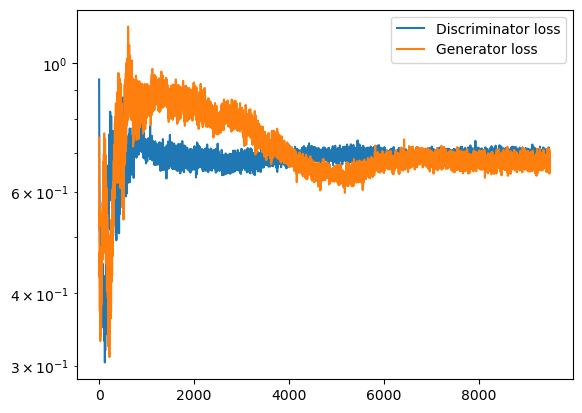

In [186]:
# Plot the loss values
plt.yscale('log')
plt.plot(d_loss_list, label='Discriminator loss')
plt.plot(g_loss_list, label='Generator loss')
plt.legend()
plt.show()

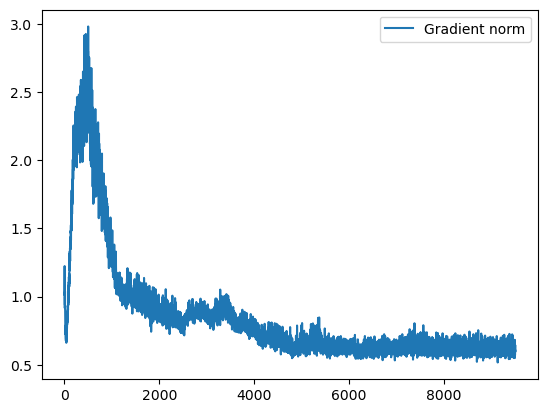

In [187]:
# Plot the gradient norm
plt.plot(gradient_norm_list, label='Gradient norm')
plt.legend()
plt.show()

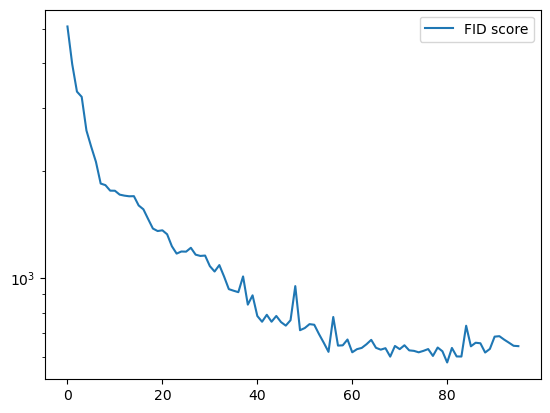

In [188]:
# Plot the FID score
plt.yscale('log')
plt.plot(fid_score_list, label='FID score')
plt.legend()
plt.show()

### Generate after the final epoch

In [189]:
synthetic_data = generate_data(best_generator, n_samples=2*original_data.shape[0])

### Save the generated data to file

In [190]:
df = pd.DataFrame(synthetic_data)
# append column names to the data 
df.columns = col_names
df.to_csv('synthetic_data/generated_data.tsv', sep='\t', index=False, header=True)

In [191]:
# save tsv to df
df = pd.read_csv('synthetic_data/generated_data.tsv', sep='\t')
# save df as sythetic data variable
synthetic_data = df

### Data distribution

In [192]:
original_data.describe()

,ENSG00000000938,ENSG00000005844,ENSG00000007312,ENSG00000010327,ENSG00000011422,ENSG00000013441,ENSG00000018280,ENSG00000027075,ENSG00000028137,ENSG00000035681,...,ENSG00000198909,ENSG00000205744,ENSG00000206503,ENSG00000213983,ENSG00000223553,ENSG00000229164,ENSG00000234745,ENSG00000240356,ENSG00000244734,ENSG00000257207
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,5.024288,4.186992,2.966604,3.887913,3.469150,5.257733,3.921770,3.666946,3.922633,3.153096,...,3.410924,4.475110,3.885223,3.743259,3.371749,4.246970,4.583119,6.049829,10.539387,6.015873
std,1.877605,2.073380,1.863493,2.123492,2.232807,1.974302,2.149881,1.869272,2.419130,1.922217,...,1.877904,1.913305,2.809661,1.869530,1.957258,1.928079,3.571637,2.385585,2.105540,2.794256
min,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,...,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,6.258173,0.873160
25%,3.952013,2.766713,0.873160,2.363176,0.873160,3.792581,2.197502,2.307693,2.129687,0.873160,...,1.858399,3.307948,1.818415,2.414356,0.873160,2.665828,1.821391,4.435172,9.160765,2.541420
50%,5.051057,4.468695,2.769204,4.067770,3.101348,5.434353,3.915935,3.636736,3.570039,3.363804,...,3.515965,4.597601,2.563295,3.795505,3.952013,4.145777,2.375495,7.033864,10.349836,7.484001
75%,6.115508,5.738644,4.545452,5.506966,4.611083,6.921511,5.630325,5.039487,5.692608,4.469831,...,4.741278,5.889671,5.789930,4.996909,5.215105,5.678701,8.669879,7.615237,11.773281,7.996443
max,9.258977,7.849886,6.844289,8.395958,9.254245,8.465110,8.392721,7.129917,9.349862,7.074172,...,7.247476,7.745178,10.161706,7.504040,6.680646,8.786847,10.316132,9.659737,16.289445,9.543337


In [193]:
df.describe()

,ENSG00000000938,ENSG00000005844,ENSG00000007312,ENSG00000010327,ENSG00000011422,ENSG00000013441,ENSG00000018280,ENSG00000027075,ENSG00000028137,ENSG00000035681,...,ENSG00000198909,ENSG00000205744,ENSG00000206503,ENSG00000213983,ENSG00000223553,ENSG00000229164,ENSG00000234745,ENSG00000240356,ENSG00000244734,ENSG00000257207
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,...,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,4.653764,3.386285,2.625206,4.380281,4.011152,5.253007,3.514820,2.946423,3.217943,3.793515,...,2.843409,4.206505,4.888455,3.729997,3.698301,4.702878,5.066391,7.303700,9.451581,3.717334
std,2.052718,2.275674,2.334966,2.907447,2.323786,2.607693,1.347565,2.032767,2.502963,1.919099,...,1.368946,1.698622,1.835838,2.723539,1.314310,1.879940,4.365400,1.960789,1.163168,1.267705
min,1.446188,0.965358,0.873186,0.994484,0.985267,1.218851,1.233679,0.874691,0.940853,1.373967,...,1.061196,1.057210,2.094523,0.886550,1.018781,1.981324,0.883670,2.854273,6.750235,1.322690
25%,2.669876,1.707659,0.886502,1.896231,1.961623,2.648175,2.363349,1.006966,1.269522,2.212270,...,1.759304,2.982536,3.351206,1.248512,2.962184,3.345492,1.859130,5.850489,8.814112,2.740044
50%,4.319135,2.311746,1.061281,3.024541,3.330576,5.282197,3.371637,2.107672,1.699606,3.075466,...,2.194798,4.080044,4.477760,2.483676,3.732325,4.326818,3.083958,7.370427,9.430235,3.461557
75%,6.568378,5.029965,5.014887,7.364829,6.404596,7.412324,4.466180,5.396201,6.314914,5.595921,...,4.172535,5.557858,6.184628,6.826456,4.496473,5.371140,7.661036,8.952475,10.173909,4.645317
max,8.405815,9.491097,7.468982,10.565292,8.571127,11.979384,7.268896,6.485597,7.665650,7.771240,...,5.624845,8.016840,9.332167,9.887122,7.516024,10.141847,16.159351,11.982749,12.899991,7.603580


### Metrics

#### Frechet Inception Distance

In [194]:
# FID score
fid_score = calculate_fid(original_data, synthetic_data)
print('FID Score: %.3f' % fid_score)

Prepared data in 0.0010023117065429688 seconds
Computed real data mean and covariance in 0.0031821727752685547 seconds
Computed generated data mean and covariance in 0.0019989013671875 seconds
ssdiff: 80.40890502929688, trace_sum: 568.4517211914062
FID Score: 648.861


d:\Apps\anaconda3\envs\krzysiu\lib\site-packages\sklearn\utils\extmath.py:370: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
